### Ноутбук содержащий бейзлайн решение для соревнования в рамках весеннего МЛ интенсива Академии Яндекса 2023

#### Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.12.0


#### Скачаем данные

Json файл с ключом к kaggle API можно сгенерировать и скачать по ссылке [тык](https://www.kaggle.com/alexnikko/account): **API -> create new API token**

После этого загрузите файл *kaggle.json* в колаб и выполните ячейку ниже - данные сами скачаются и распакуются

In [ ]:
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c ml-intensive-of-yandex-academy-2023
!unzip ml-intensive-of-yandex-academy-2023.zip 

 96% 253M/263M [00:03<00:00, 114MB/s]
100% 263M/263M [00:03<00:00, 83.9MB/s]


#### Считаем данные и посмотрим какую-нибудь информацию по ним

In [ ]:
train_data = pd.read_pickle('data_train')
test_data = pd.read_pickle('data_test')

print(f'Train data keys: {train_data.keys()}')
print(f'Test data keys: {test_data.keys()}\n')
print(f'Shape of train images: {train_data["images"].shape}')
print(f'Shape of test images: {test_data["images"].shape}\n')
print(f'Unique labels: {set(train_data["labels"])}\n')
print(f'Classes distribution: {pd.Series(train_data["labels"]).value_counts(normalize=True)}')

Train data keys: dict_keys(['section', 'labels', 'images'])
Test data keys: dict_keys(['section', 'images'])

Shape of train images: (50000, 32, 32, 3)
Shape of test images: (25000, 32, 32, 3)

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Classes distribution: 1    0.19300
2    0.15190
3    0.11250
4    0.09882
5    0.09208
7    0.07752
6    0.07718
0    0.06682
8    0.06664
9    0.06354
dtype: float64


Видим, что в трейне - **50к** картинок, в тесте - **25к**. 

Классов всего **10** - от 0 до 9 (цифры)

Есть дисбаланс классов: например, домов с номерами 1 **в 3 раза больше**, чем домов с номерами 9

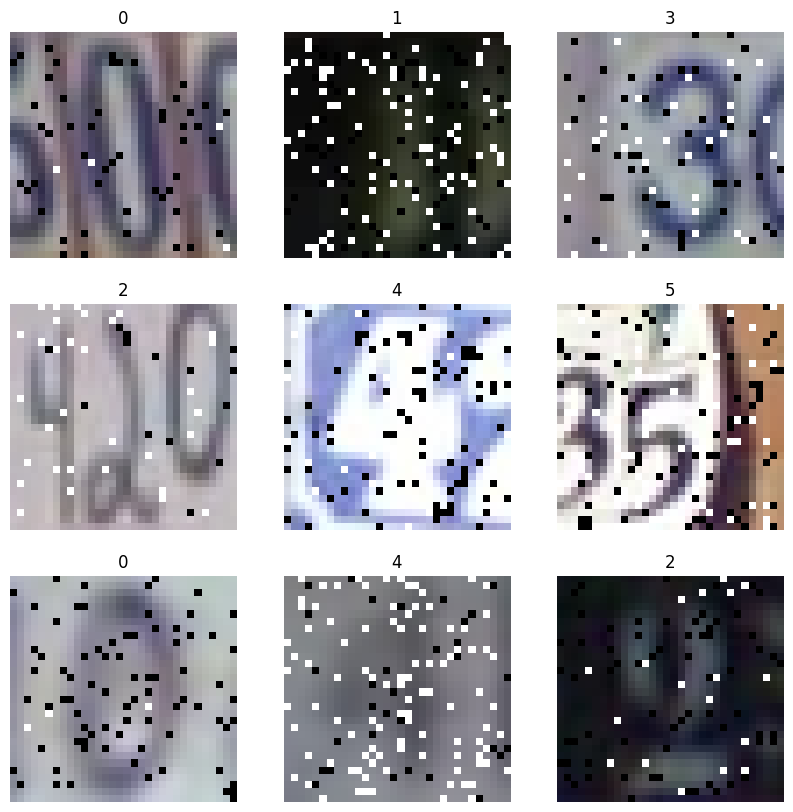

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(len(train_data['images']))
    image = train_data['images'][idx]
    label = train_data['labels'][idx]

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(label)
    plt.axis("off")

#### Создадим простую модель

В качестве нейронной сети возьмем просто перцептрон, то есть двуслойную нейросеть (с двумя линейными слоями)

Во-первых, нам необходимо отмасштабировать картинки из целочисленного диапазона от 0 до 255 (значения пикселей) в вещественный диапазон от 0 до 1. За это будет отвечать слой **Rescaling**.

Во-вторых, нужно "распрямить" картинку. На вход нейронной сети подается трехканальное изображение (RGB) с высотой и шириной равными 32. Таким образом необходимо из размерности 32x32x3 сделать вектор размерности 32*32*3. За это отвечает слой **Flatten**.

Дальше схема простая: x -> Linear -> Relu -> Linear

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

#### Зададим оптимизатор, функцию потерь и метрики

В качестве оптимизатора возьмем **RMSprop** с параметрами по умолчанию

В качестве функции потерь нам необходимо использовать **Crossentropy** (стандартный лосс для задач классификации)

В качетсве метрик, который будем считать будем использовать accuracy - целевая метрика нашего соревнования

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)

#### Обучение модели

Параметры:
- x - тренировочные картинки (numpy array)
- y - тренировочные лейблы (numpy array)
- batch_size - размер батча (пакета)
- epochs - количество эпох обучения 
- validation_split - сколько процентов тренировочных данных использовать в качестве валидации (в данном случае 0.2 - это 20%)
- shuffle - перешивать данные перед началом каждой эпохи или нет

In [ ]:
model.fit(
    x=train_data['images'],
    y=train_data['labels'],
    batch_size=32,
    epochs=1,
    validation_split=0.2,
    shuffle=True
)

1250/1250 [==============================] - 16s 12ms/step - loss: 2.2967 - sparse_categorical_accuracy: 0.1779 - val_loss: 2.2555 - val_sparse_categorical_accuracy: 0.1895


#### Предсказание

Сделаем предсказание модели на тестовом датасете и создадим сабмит

In [ ]:
preds = model.predict(test_data['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('sub.csv', index=False)

782/782 [==============================] - 3s 3ms/step


#### Дальнейшие шаги

В какую сторону нужно думать, чтобы улучшить качество:

- **Модель.** Сейчас мы используем простую двуслойную нейронную сеть с линейными слоями. Однако для классификации изображений принято использовать сверточные нейронные сети. Их реализацией и стоит заняться в первую очередь.
- **Данные.** Если посмотреть на данные (картинки), то можно понять, что они не идеальны. Нужно придумать способы, как улучшить их качество. + можно использовать аугментации.
- **Схема тренировки.** В данном ноутбуке практически все параметры заданы по умолчанию, однако можно с ними поэксперементировать. Различные оптимизаторы, learning rate, schedulers - на всё это стоит обратить внимание.